In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split, GridSearchCV
import scikitplot as skplt
from sklearn.metrics import confusion_matrix
from scipy.stats import uniform, randint

In [53]:
df = pd.read_csv('DATASET/MyDataset.csv')

In [54]:
df = df.drop(['login'], axis=1)
df = df.drop(['paymentType'], axis=1)
df = df.drop(['activeLifeM1'], axis=1)
# df = df.drop(['activeLifeM3'], axis=1)

In [55]:
df.duplicated(keep=False).sum()

4

In [56]:
df.drop('outflow', axis=1).duplicated(keep=False).sum()

4

In [57]:
df = df.drop_duplicates()

In [58]:
df.columns

Index(['mounth', 'year', 'failCount', 'failPause', 'failMax', 'lifeTime',
       'activeLife', 'calls', 'rejectedCalls', 'unansweredCalls',
       'tariffPrice', 'tariffSpeed', 'addServ', 'addItv', 'gender', 'payments',
       'paymentSum', 'coefPayment3', 'serviceTask', 'lk', 'bigFailure', 'sms',
       'coefPrice', 'coefPayment', 'activeLifeM3', 'region', 'outflow'],
      dtype='object')

In [59]:
df['day'] = 1
df = df.rename(columns={"mounth": "month"})
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day']])

In [60]:
# Пробелма с данными в этом месяце
df = df[(df['month'] != 1) & (df['year'] != 2021)]

In [49]:
def normalize(group, columns):
    for col in columns:
        X_min = group[col].min()
        X_max = group[col].max()
        # Защита от деления на ноль
        range_span = X_max - X_min
        if range_span == 0:
            group[f'{col}_n'] = 0
        else:
            group[f'{col}_n'] = (group[col] - X_min) / range_span
    return group

# Укажите колонки для нормализации
# columns_to_normalize = ['paymentSum', 'tariffPrice', 'tariffSpeed']
columns_to_normalize = ['activeLifeM1', 'activeLifeM3', ]


# Применяем нормализацию по месяцам
df = df.groupby('datetime', group_keys=False).apply(normalize, columns=columns_to_normalize)

C:\Users\user\AppData\Local\Temp\ipykernel_6620\3419992571.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('datetime', group_keys=False).apply(normalize, columns=columns_to_normalize)


In [61]:
df = df.drop(['year', 'datetime', 'day'], axis=1)

In [62]:
X = df.drop('outflow', axis=1).values
y = df['outflow'].values

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [33]:
pool = Pool(data=X, label=y)

In [64]:
train_data = Pool(X_train, y_train)
test_data = Pool(X_test, y_test)    

In [34]:
# Настройка параметров модели
params = {
    'auto_class_weights': 'SqrtBalanced', 
    'iterations': 5000,          # Количество итераций (деревьев)
    'depth': 2,                 # Глубина дерева
    'learning_rate': 0.01,       # Скорость обучения
    'loss_function': 'Logloss',
    'l2_leaf_reg': 10,
    'eval_metric': 'F1'

}

# Запуск перекрестной проверки
cv_results = cv(
    params=params, 
    pool=pool, 
    fold_count=5,               # Количество фолдов для кросс-валидации
    shuffle=True,               # Перемешивание данных
    partition_random_seed=0,    # Случайное зерно для репликации результатов
    plot=True                   # Построение графика
)

# Результаты кросс-валидации
print(cv_results)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.7714062	test: 0.7717560	best: 0.7717560 (0)	total: 9.36ms	remaining: 46.8s
1:	learn: 0.7646597	test: 0.7637479	best: 0.7717560 (0)	total: 13.8ms	remaining: 34.5s
2:	learn: 0.7646597	test: 0.7637479	best: 0.7717560 (0)	total: 18.3ms	remaining: 30.5s
3:	learn: 0.7689659	test: 0.7693751	best: 0.7717560 (0)	total: 22.4ms	remaining: 28s
4:	learn: 0.7990356	test: 0.7976835	best: 0.7976835 (4)	total: 27.6ms	remaining: 27.6s
5:	learn: 0.7949427	test: 0.7924825	best: 0.7976835 (4)	total: 35.3ms	remaining: 29.4s
6:	learn: 0.7651476	test: 0.7642388	best: 0.7976835 (4)	total: 42.9ms	remaining: 30.6s
7:	learn: 0.7647816	test: 0.7639933	best: 0.7976835 (4)	total: 49.3ms	remaining: 30.8s
8:	learn: 0.7647816	test: 0.7639933	best: 0.7976835 (4)	total: 56.6ms	remaining: 31.4s
9:	learn: 0.7647816	test: 0.7639933	best: 0.7976835 (4)	total: 62ms	remaining: 30.9s
10:	learn: 0.7647816	test: 0.7639933	best: 0.7976835 (4)	total: 67ms	remaining: 30.4s
11:	learn: 0.7675803	test

In [65]:
model = CatBoostClassifier(#class_weights=[1, 10],
                           auto_class_weights="SqrtBalanced",
                           learning_rate=0.01,
                           eval_metric='F1',
                        #    eval_metric="AUC:hints=skip_train~false",
                           iterations=5000,
                           l2_leaf_reg=10,
                           max_depth=2
                           ) 

model.fit(
    train_data, 
    eval_set=test_data)

0:	learn: 0.7884850	test: 0.8037717	best: 0.8037717 (0)	total: 5.52ms	remaining: 27.6s
1:	learn: 0.7914947	test: 0.8074126	best: 0.8074126 (1)	total: 10.3ms	remaining: 25.7s
2:	learn: 0.8551627	test: 0.8668750	best: 0.8668750 (2)	total: 15.7ms	remaining: 26.2s
3:	learn: 0.8627002	test: 0.8784714	best: 0.8784714 (3)	total: 20.3ms	remaining: 25.4s
4:	learn: 0.8585444	test: 0.8686857	best: 0.8784714 (3)	total: 24.9ms	remaining: 24.9s
5:	learn: 0.8585444	test: 0.8686857	best: 0.8784714 (3)	total: 29.3ms	remaining: 24.4s
6:	learn: 0.8626716	test: 0.8778534	best: 0.8784714 (3)	total: 33.6ms	remaining: 24s
7:	learn: 0.8629056	test: 0.8784714	best: 0.8784714 (3)	total: 38.1ms	remaining: 23.8s
8:	learn: 0.7974453	test: 0.8196114	best: 0.8784714 (3)	total: 42.6ms	remaining: 23.6s
9:	learn: 0.8477243	test: 0.8650720	best: 0.8784714 (3)	total: 46.9ms	remaining: 23.4s
10:	learn: 0.7987791	test: 0.8179159	best: 0.8784714 (3)	total: 51ms	remaining: 23.1s
11:	learn: 0.7986344	test: 0.8184567	best: 0.8

Text(0.5, 1.0, 'Feature Importance')

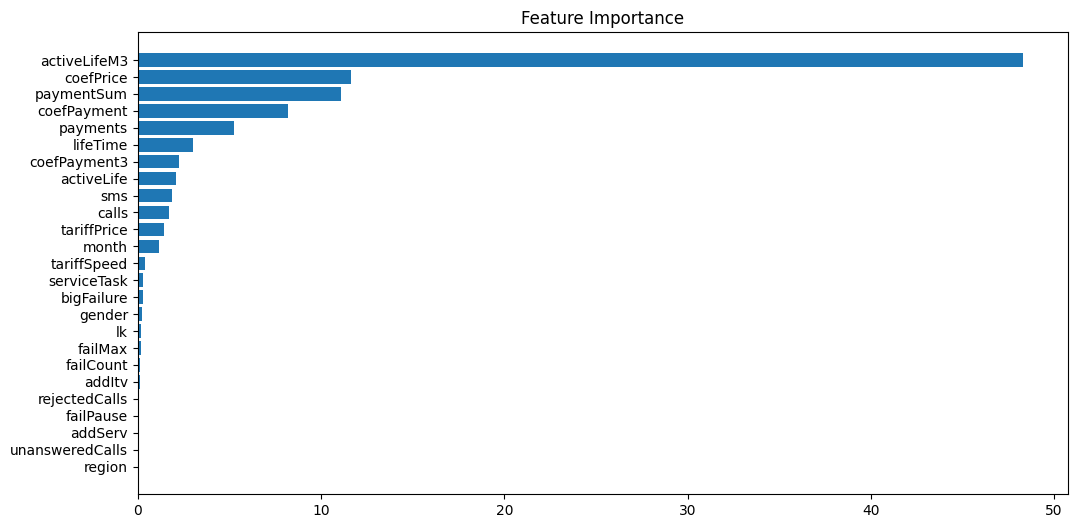

In [84]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(df.drop(['outflow'], axis=1).columns)[sorted_idx])
plt.title('Feature Importance')

In [67]:
# Предсказание классов
predictions = model.predict(X_test)
print("Predicted classes:", predictions)

# Предсказание вероятностей
probabilities = model.predict_proba(X_test)
print("Predicted probabilities:", probabilities)

Predicted classes: [0 0 0 ... 0 0 0]
Predicted probabilities: [[9.99661972e-01 3.38028470e-04]
 [9.99511862e-01 4.88137530e-04]
 [9.91191406e-01 8.80859416e-03]
 ...
 [9.82424916e-01 1.75750836e-02]
 [9.99721328e-01 2.78671940e-04]
 [9.99143486e-01 8.56514385e-04]]


c:\Users\user\Desktop\LEO\ML_outflow_fridom\.venv\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


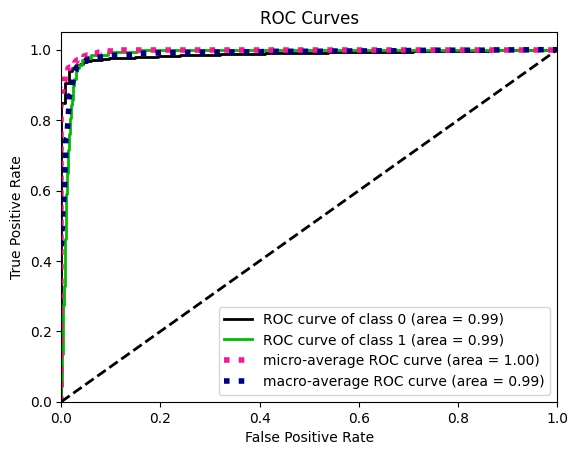

In [68]:
y_true = y_test
y_probas = probabilities
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

In [81]:
X_test

array([[     11,       2,   45634, ...,     948, 7991332,       0],
       [      5,       0,       0, ...,     967, 7970429,       0],
       [      5,       0,       0, ...,    1161, 7774647,       0],
       ...,
       [      8,       1,    6301, ...,       0, 4963877,       1],
       [      2,       0,       0, ...,     914, 8014998,       1],
       [     10,       0,       0, ...,     748, 7950055,       0]],
      dtype=int64)

In [78]:
# Задайте порог
threshold = 0.5

# Вероятности для класса 1
prob_class_1 = y_probas[:, 1]

# Прогнозы на основе порога
predictions = (prob_class_1 >= threshold).astype(int)

# Подсчитайте матрицу ошибок
tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()

percent_true_positive = (tp / (tp + fn)) * 100
percent_false_positive = (fp / (fp + tn)) * 100

# X_test_df = pd.DataFrame(X_test, columns=df.drop(['outflow']).columns)

print('Всего 1:', sum(y_test))
print('Всего 0:', X_test[-1].count())
print(f'Истинные положительные: {tp}')
print(f'Ложные положительные: {fp}')
print(f'Ложные отрицательные: {fn}')
print(f'Истинные отрицательные: {tn}')
print(f'Процент верно угаданных единиц: {percent_true_positive:.2f}%')
print(f'Процент нулей, предсказанных как единицы: {percent_false_positive:.2f}%')

Всего 1: 134


AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [88]:
# Задайте процент допустимых ошибок в нулях
percent_error_allowed = 1

# Вероятности для класса 1
prob_class_1 = y_probas[:, 1]

total_zeros = sum(y_true == 0)

# Определите количество допустимых ошибок
allowed_errors = int(total_zeros * percent_error_allowed / 100)

sorted_prob_class_1 = np.sort(prob_class_1[y_true == 0])
threshold_for_error = sorted_prob_class_1[-allowed_errors] if allowed_errors > 0 else 1.0

predictions = (prob_class_1 >= threshold_for_error).astype(int)

tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()

percent_true_positive = (tp / (tp + fn)) * 100
percent_false_positive = (fp / (fp + tn)) * 100

print('Всего 1:', sum(y_true))
print('Всего 0:', total_zeros)
print(f'Истинные положительные: {tp}')
print(f'Ложные положительные: {fp}')
print(f'Ложные отрицательные: {fn}')
print(f'Истинные отрицательные: {tn}')
print(f'Процент верно угаданных единиц: {percent_true_positive:.2f}%')
print(f'Процент нулей, предсказанных как единицы: {percent_false_positive:.2f}%')
print(f'Выбранный порог для ошибки в нулях: {threshold_for_error:.2f}')


Всего 1: 134
Всего 0: 3303
Истинные положительные: 78
Ложные положительные: 33
Ложные отрицательные: 56
Истинные отрицательные: 3270
Процент верно угаданных единиц: 58.21%
Процент нулей, предсказанных как единицы: 1.00%
Выбранный порог для ошибки в нулях: 0.85
